# Exploratory Data Analysis

## Overview
This notebook conducts exploratory data analysis (EDA) on Amazon product review data to understand user preferences, product characteristics, and market dynamics. The insights derived from this analysis will inform the design and feature engineering for my recommendation system.

## Objectives
The primary goals of this analysis are to:

### **User Behavior Analysis**
- Understand user rating patterns and review frequency
- Analyze user engagement across different product categories
- Identify cold-start scenarios (users with no previous purchase history)
- Examine user diversity in category preferences

###  **Product Characteristics**
- Investigate product popularity/pricing and their relationship to ratings 
- Examine store/brand performance and reputation
- Identify top-performing products in each category

###  **Market Insights**
- Explore category-wise user engagement and product availability
- Understand temporal trends in reviews and ratings
- Analyze the relationship between product features (price, brand) and user satisfaction
- Identify potential data quality issues and outliers

###  **Recommendation System Design Insights**
- Assess how sparse the data is + which features may be more important than others to inform system design choices

## Key Research Questions
1. **Rating Distribution**: How are user ratings distributed? Are there biases in the rating system?
2. **User Engagement**: What is the typical user engagement pattern? How many categories do users typically interact with?
3. **Product Popularity**: Which products and categories are most popular? What drives popularity?
4. **Price-Rating Relationship**: Is there a correlation between product price and user satisfaction?
5. **Temporal Trends**: How have user preferences and review patterns evolved over time?
6. **Data Quality**: Are there outliers or data quality issues that need addressing?

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np

from matplotlib.ticker import FuncFormatter, MultipleLocator

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
#train_df = pd.read_parquet("merged_data/merged_train_df_old.parquet", engine="pyarrow")
train_df = pd.read_parquet("gs://amazon-reviews-project/merged_train_df_old.parquet", engine="pyarrow")

## Data Structure

Let's examine the basic structure and scale of the dataset to understand the scope this project.

In [19]:
train_df.shape

(85948425, 11)

In [22]:
train_df.head()

,user_id,parent_asin,rating,timestamp,history,category,title,average_rating,price,store,price_missing,datetime,year
0,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B096WPNG8Q,5.00,1600542207688,None,Patio_Lawn_and_Garden,"Mosser Lee ML0560 Spanish Moss, 250 Cubic Inches",4.60,4.97,Mosser Lee,0,2020-09-19 19:03:27.688,2020
1,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B000BQT5IG,3.00,1602272552200,B096WPNG8Q,Patio_Lawn_and_Garden,"Combat Indoor and Outdoor Ant Killing Gel, 27 ...",4.40,5.48,Combat,0,2020-10-09 19:42:32.200,2020
2,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B002FGU2MI,4.00,1624053736863,B096WPNG8Q B000BQT5IG,Patio_Lawn_and_Garden,SWIMLINE HYDROTOOLS Mini Venturi Pool & Spa Va...,3.90,16.93,Swimline,0,2021-06-18 22:02:16.863,2021
3,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B073V7N6RQ,5.00,1566941698710,None,Patio_Lawn_and_Garden,Raisman Rewind Recoil Starter Assembly Compati...,4.50,25.99,Raisman,0,2019-08-27 21:34:58.710,2019
4,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B01J0RIRUS,4.00,1566941843328,B073V7N6RQ,Patio_Lawn_and_Garden,AUTOKAY Recoil Pull Start Compatible with Brig...,4.00,16.99,AUTOKAY,0,2019-08-27 21:37:23.328,2019


In [20]:
# number of product categories
print(train_df["category"].nunique())

14


In [21]:
# number of unique users
print(train_df["user_id"].nunique())

6051995


In [ ]:
# number of unique products
print(train_df["parent_asin"].nunique())

2870233


 With 6 million users and 2.9 million products, it is unlikely that the average user interacts with a lot of products. This training data sparsity may cause issues later on as we build our recommendation systems.the large scale of the data will require memory efficient algorithms that prevent RAM overflows.

 Now let's examine missing values to understand how complete the data is.


In [3]:
columns_to_check = ["user_id", "parent_asin", "rating", "timestamp", "history", "category", "title", "average_rating", "store"]

null_proportions = train_df[columns_to_check].isna().sum() / len(train_df)
display(null_proportions.to_frame(name="Proportion of Nulls"))

,Proportion of Nulls
user_id,0.000000
parent_asin,0.000000
rating,0.000000
timestamp,0.000000
history,0.131600
category,0.000000
title,0.041431
average_rating,0.000000
store,0.053116


We will fill the missing values in the store and title columns with "Unknown" and "Untitled", respectively.

In [ ]:
train_df["store"] = train_df["store"].fillna("Unknown")
train_df["title"] = train_df["title"].fillna("Untitled")

In [13]:
train_df["rating"].describe()

count   85948425.00
mean           4.32
std            1.19
min            1.00
25%            4.00
50%            5.00
75%            5.00
max            5.00
Name: rating, dtype: float64

We can see user ratings are very right-skewed, given the median to maximum value are all 5 star reviews. This may evidence of selection bias (only users with positive experiences leave reviews) or many of the reviews could also be fake.

In [14]:
filtered_train_df = train_df[train_df.price != -1]

filtered_train_df["price"].describe()

count   55524260.00
mean          41.55
std          205.13
min            0.00
25%           12.99
50%           21.10
75%           38.26
max        99999.00
Name: price, dtype: float64

Some unrealistic prices (like 0 and 99999) may need to be filtered out.

In [7]:
train_df[train_df["price"] == 99999].head(30)

,user_id,parent_asin,rating,timestamp,history,category,title,average_rating,price,store,price_missing
59478838,AHW7ETGBKGX6DCG2LBAG5YAXU46A,B0084GF7GO,5.00,1380352982000,B00005IBXK B00008ZCKR B0000YRJT6 B088HF4YNH B0...,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
59491178,AERIZ2VWHWFJRZZV73KN7BUCKK6A,B0084GF7GO,5.00,1431356345000,B005OK1I98 B008AZ0RPU B0088MUKVG,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
59686075,AHCID3KYWWFMOHDS6JC3R5QY3SOQ,B0084GF7GO,4.00,1396554460000,B0039PIM8U B0000CFPYA B07C5FB9BS B00006IUWM B0...,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
59759757,AFCW6KHLTABNMOYLRAVXTYVLIK3Q,B0084GF7GO,4.00,1432739386000,B0BJHYD8XC B00IZA1998 B002CCEMK8 B006TIHDW0 B0...,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
59854057,AGLS3U2N5L4232G3FMFKPXXVPIYA,B0084GF7GO,5.00,1380660979000,B000YPQ91U,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
59947351,AFXHHAY4XDFKDA4W6DFIRX3V35WQ,B0084GF7GO,5.00,1424982579000,B005N7FBAY B0BFX2CTBM B07BRX9PK8 B0029XHQXK B0...,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
59969780,AFRR2YHKZ4BWBJ73MQLWAVVXRTBA,B0084GF7GO,5.00,1419195835000,None,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
60082859,AE5VQ3HYWNSVSP44C4Z64OM6N66Q,B0084GF7GO,5.00,1414503828000,None,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
60146490,AEWFKMSBU3RQ7Q5LIHBQUAACTUVQ,B0084GF7GO,5.00,1416770030000,B00EYMCSWS,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0
60322127,AFYOESGWGSAB5MM226UAUSZLN7KQ,B0084GF7GO,1.00,1406852265000,B00004SZ10 B077N8YGMP B006W0RDV6 B008OQN7RA B0...,Home_and_Kitchen,FITMAKER WE23 FITMAKERFWE 35 inches Blue,3.80,99999.00,FITMAKER,0


It seems all the products that cost $99,999 are from one brand. I can not verify the brand or product online so I will remove these reviews from the dataset.

In [6]:
train_df = train_df[train_df["price"] != 99999]

In [6]:
train_df[train_df["price"] == 0].head(30)

,user_id,parent_asin,rating,timestamp,history,category,title,average_rating,price,store,price_missing
2562892,AFUSY44MXVDBXRLBAGDOXZIPBRVA,B003D6MC3Q,5.00,1581476628576,B01MU2YKID B001O0TWXG B00ANJNFCI B01MTAE8W6 B0...,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0
2588471,AEBZFRQHRGN4G5CUEXAJQWPIWGUQ,B00EY7J5DS,3.00,1424208394000,B004H71Z2E B001AQD03W B006IGZWB2,Movies_and_TV,Sharknado (Gag Reel),3.70,0.00,None,0
2611753,AF7GBLQELZNCHQCJPJ5CSJDOB3MQ,B003D6MC3Q,3.00,1480437122000,B00LI0VA4Q B003ITF6MM B01D5J0IT0 B00UY0Q85W,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0
2613226,AEW6DQRE6GSOIU5VAPACM56T7ADQ,B003D6MC3Q,5.00,1456002722000,B000Z4KN1W B000I5XCZC B004XC5LR8 B00C4Z68U0 B0...,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0
2615967,AHVFOMUHI6ABFZO6AAF7C5NY47QA,B000WSE13C,5.00,1446131521000,B005C8DB06 B00N9SR7HO B00ESNE696 B014CRIF62,Movies_and_TV,Couples Counseling,4.00,0.00,None,0
2644630,AGJVU665TYMT6VDRLBJSJ335PMUA,B003D6MC3Q,1.00,1492703496000,B00S6MBGY8 B004DK745M B00005LDCS B004UVYQYQ B0...,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0
2684092,AFKCIJWTRGR4PW3KWUMWP7L5OIWA,B003D6MC3Q,4.00,1547530616765,B00E8S2JZ4 B00E3IZIM0 B001KOFH2G B0000AOX0O B0...,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0
2690699,AFDDKXGXDPPAHZ2NAGWHFTU7ETMA,B003D6MC3Q,3.00,1368360590000,B003L77GBU B002VJ05DU B001W79MHM B0081QF6WW B0...,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0
2698737,AHZSUGCJIUILJFV6I7OAEQNAKCBA,B003D6MC3Q,5.00,1482340983000,B001O22ELQ B001KEGRA2 B00712PDRA B003JMENGS B0...,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0
2773370,AH6TJ4GSPAK5T3ND7Q7ADPYARVDQ,B003D6MC3Q,5.00,1464198340000,B017OJL48G B001F76OKC B00GT2GI0E B00Q6DCXKA B0...,Movies_and_TV,Learn Along with Sesame,4.60,0.00,None,0


It seems a lot of the products that cost $0 are TV shows or books with free trials as well as free-to-play video games. As free trials affect a users likelihood to buy a product, these are valid prices and they should be kept in the dataset.

We can see the new price distribution without the outliers now:

In [7]:
filtered_train_df = train_df[train_df.price != -1]

filtered_train_df["price"].describe()

count   55524066.00
mean          41.20
std           84.67
min            0.00
25%           12.99
50%           21.10
75%           38.26
max        24995.00
Name: price, dtype: float64

In [7]:
train_df["datetime"] = pd.to_datetime(train_df["timestamp"], unit='ms')
train_df["year"] = train_df["datetime"].dt.year
train_df.head()

,user_id,parent_asin,rating,timestamp,history,category,title,average_rating,price,store,price_missing,datetime,year
0,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B096WPNG8Q,5.00,1600542207688,None,Patio_Lawn_and_Garden,"Mosser Lee ML0560 Spanish Moss, 250 Cubic Inches",4.60,4.97,Mosser Lee,0,2020-09-19 19:03:27.688,2020
1,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B000BQT5IG,3.00,1602272552200,B096WPNG8Q,Patio_Lawn_and_Garden,"Combat Indoor and Outdoor Ant Killing Gel, 27 ...",4.40,5.48,Combat,0,2020-10-09 19:42:32.200,2020
2,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B002FGU2MI,4.00,1624053736863,B096WPNG8Q B000BQT5IG,Patio_Lawn_and_Garden,SWIMLINE HYDROTOOLS Mini Venturi Pool & Spa Va...,3.90,16.93,Swimline,0,2021-06-18 22:02:16.863,2021
3,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B073V7N6RQ,5.00,1566941698710,None,Patio_Lawn_and_Garden,Raisman Rewind Recoil Starter Assembly Compati...,4.50,25.99,Raisman,0,2019-08-27 21:34:58.710,2019
4,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B01J0RIRUS,4.00,1566941843328,B073V7N6RQ,Patio_Lawn_and_Garden,AUTOKAY Recoil Pull Start Compatible with Brig...,4.00,16.99,AUTOKAY,0,2019-08-27 21:37:23.328,2019


In [9]:
print("Earliest date:", train_df.datetime.min())
print("Latest date:", train_df.datetime.max())

Earliest date: 1997-12-31 15:29:20
Latest date: 2021-08-11 00:56:53.931000


## User Behavior 

In [56]:
# most reviewed categories
print(train_df['category'].value_counts())

Home_and_Kitchen               21389082
Clothing_Shoes_and_Jewelry     16800741
Electronics                    13096427
Movies_and_TV                   7090363
Health_and_Household            5439332
Beauty_and_Personal_Care        4837881
Toys_and_Games                  3114947
Grocery_and_Gourmet_Food        2994548
Sports_and_Outdoors             2867743
Patio_Lawn_and_Garden           2547339
Cell_Phones_and_Accessories     2208880
Office_Products                 1441447
Arts_Crafts_and_Sewing          1382868
Video_Games                      736827
dtype: int64


In [15]:
# most reviewed products
print(train_df['title'].value_counts().head(10))

title
Funny Civil Engineers TShirt I'm A Crazy Civil Engineering T-Shirt                                                                                                                                          72450
Fire TV Stick with Alexa Voice Remote, streaming media player - Previous Generation                                                                                                                         44837
Echo Dot (2nd Generation) - Smart speaker with Alexa - White                                                                                                                                                39133
Fire TV Stick 4K streaming device with Alexa Voice Remote (includes TV controls) | Dolby Vision                                                                                                             33989
Mellanni RV Bedding Short Queen - Double Brushed Microfiber Camper Bunk Sheets - Durable and Breathable Cooling Sheets - Fits Mattress Up to 10'' - Deep P

In [58]:
# user with most reviews
print(train_df['user_id'].value_counts().head(5))

AG73BVBKUOH22USSFJA5ZWL7AKXA    9546
AGZZXSMMS4WRHHJRBUJZI4FZDHKQ    6587
AEIIRIHLIYKQGI7ZOCIJTRDF5NPQ    6356
AH665SQ6SQF6DXAGYIQFCX76LALA    6259
AG375WAXLZ7PIOQKIQ6KQB4J3JVQ    5110
dtype: int64


In [11]:
# percentage of reviews for users that have not rated previous items (cold start for recommendations)
cold_start = train_df["history"].isna().sum()/len(train_df)
print(f"{cold_start:.2%}")

13.16%


This shows most users that write reviews have reviewed other products before (86.84%), which means our models should be able to effectively learn user preferences based on their previous reviews.

In [8]:
# helper functions to label axes for large numbers
def millions(x, pos):
    return f'{x*1e-6:.1f}M'

def thousands(x, pos):
    if x >= 1e3:
        return f'{x*1e-3:.0f}K'

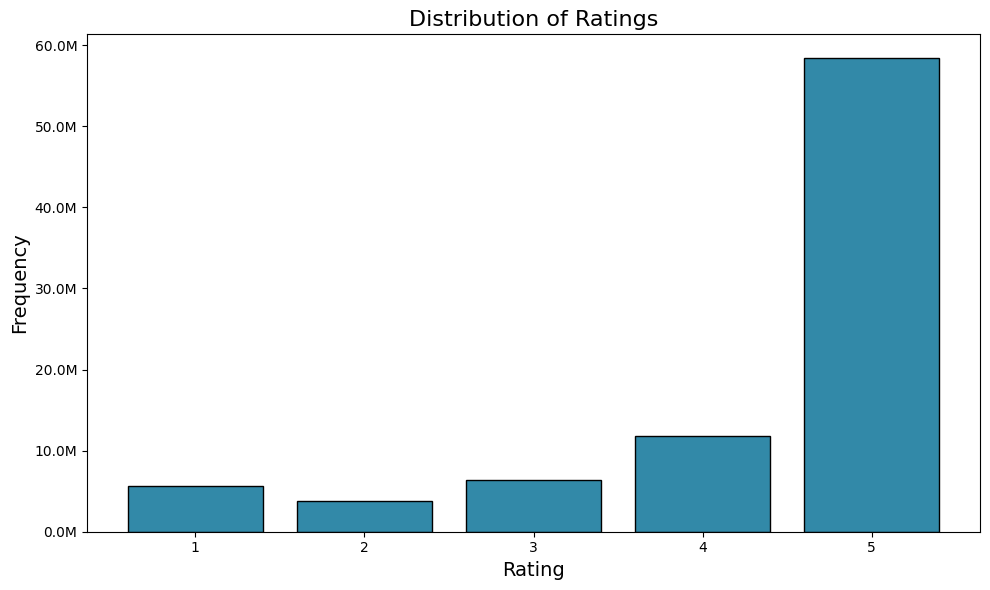

In [9]:
# distribution of ratings
plt.figure(figsize=(10, 6))
ax = train_df["rating"].plot.hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="#3289a8", edgecolor='black')
ax.set_title("Distribution of Ratings")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.yaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.show()

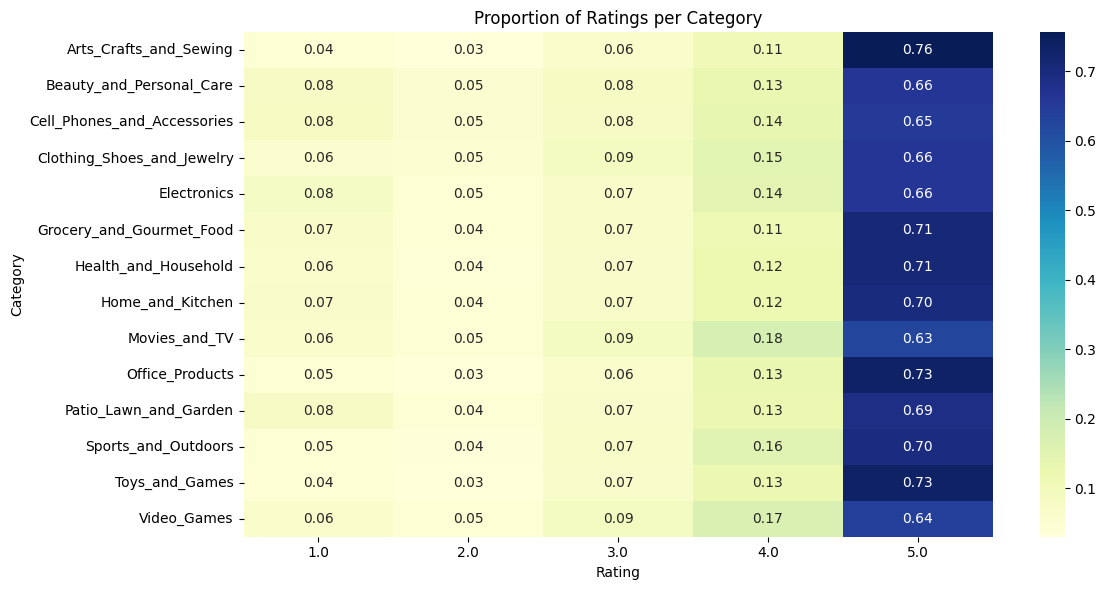

In [19]:
# proportion of ratings by category
rating_table = (train_df.groupby(['category', 'rating']).size().unstack(fill_value=0))
rating_table_norm = rating_table.div(rating_table.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
sns.heatmap(rating_table_norm, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Proportion of Ratings per Category")
plt.xlabel("Rating")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

This verifies what we saw in the percentile data for ratings above as most of the ratings are 5/5, which skews the mean and median towards highly rated values.

In [20]:
# average rating by category
print(train_df.groupby("category")["rating"].mean().sort_values(ascending=False))

category
Arts_Crafts_and_Sewing        4.50
Toys_and_Games                4.48
Office_Products               4.47
Sports_and_Outdoors           4.42
Health_and_Household          4.37
Grocery_and_Gourmet_Food      4.35
Home_and_Kitchen              4.35
Clothing_Shoes_and_Jewelry    4.31
Patio_Lawn_and_Garden         4.30
Video_Games                   4.27
Electronics                   4.26
Movies_and_TV                 4.26
Beauty_and_Personal_Care      4.25
Cell_Phones_and_Accessories   4.22
Name: rating, dtype: float64


Some categories have less 5 star reviews than others (movies/tv and video games). This could be because customers who play video games and watch movies are more critical of those products. On the other hand, arts and craft products have the most 5 star reviews (and the highest average), indicating those customers could be more lenient.

In [21]:
# average number of products a user reviews
avg_unique_products = train_df.groupby("user_id")['parent_asin'].nunique().mean()
print(f"{avg_unique_products:.2f}")

14.20


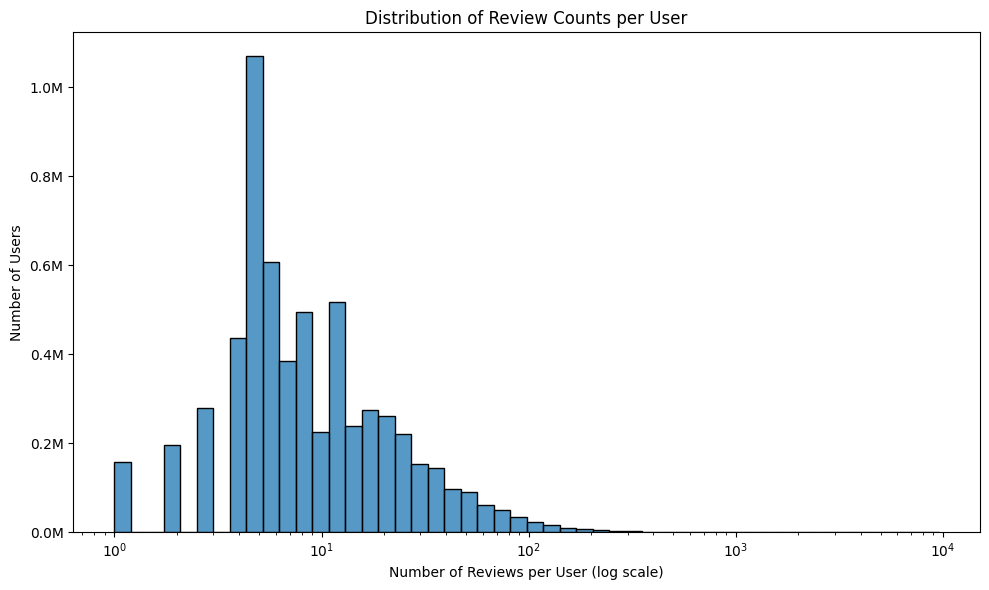

In [23]:
# plot the number of reviews per user
user_counts = train_df['user_id'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_counts, bins=50, log_scale=(True, False), edgecolor='black')

plt.xlabel("Number of Reviews per User (log scale)")
plt.ylabel("Number of Users")
plt.title("Distribution of Review Counts per User")

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

plt.tight_layout()
plt.show()

Most users review around 14 unique products on average, which suggests there is some data for building preference profiles. However, given the large scale of the data, 14 products may still be too small and the model may not be able to accurately learn user preferences.

In [ ]:
# number of users with more than 100 reviews (outliers)
user_review_count = train_df.groupby("user_id").size()
print((user_review_count > 100).sum())

61332


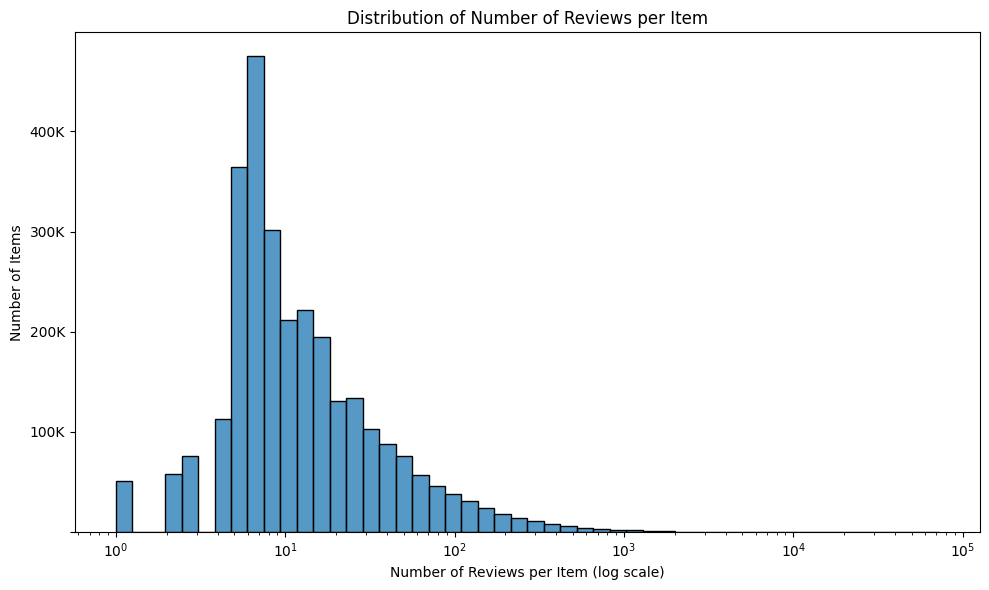

In [27]:
# plot number of reviews per product
item_counts = train_df['parent_asin'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(item_counts, bins=50, log_scale=(True, False), edgecolor='black')

plt.title("Distribution of Number of Reviews per Item")
plt.xlabel("Number of Reviews per Item (log scale)")
plt.ylabel("Number of Items")

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))

plt.tight_layout()
plt.show()

In [28]:
# average number of reviews per product
print(train_df.groupby("parent_asin").size().mean())

29.944755356098266


In [29]:
# how many categories does a user interact with
categories_per_user = train_df.groupby('user_id')['category'].nunique()
print(categories_per_user.describe())

count   6051995.00
mean          1.87
std           1.49
min           1.00
25%           1.00
50%           1.00
75%           2.00
max          14.00
Name: category, dtype: float64


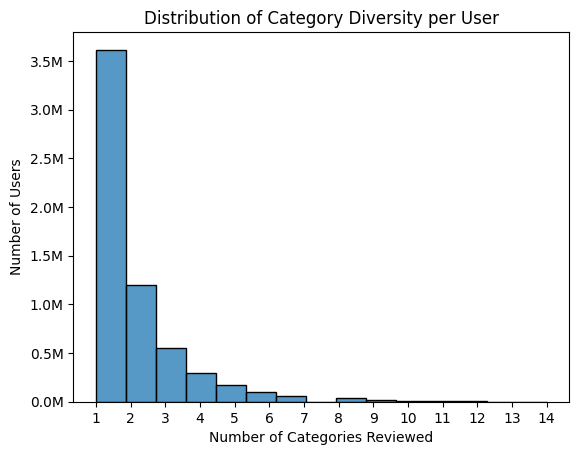

In [30]:
sns.histplot(categories_per_user, bins=15, edgecolor='black')
plt.title("Distribution of Category Diversity per User")
plt.xlabel("Number of Categories Reviewed")
plt.ylabel("Number of Users")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(range(1, categories_per_user.max() + 1))
plt.show()

The above plot and descriptive statistics show that most users only engage with 1 category (I define engage as leaving a review).

Since there is a lot of sparsity between user-category interactions, we need to design a recommendation architecture that can adapt to limited information on users (matrix factorization?)

I am interested in seeing if users are less interested in more expensive products. While there is probably no linear relationship between the 2 features, it is still an interesting question.

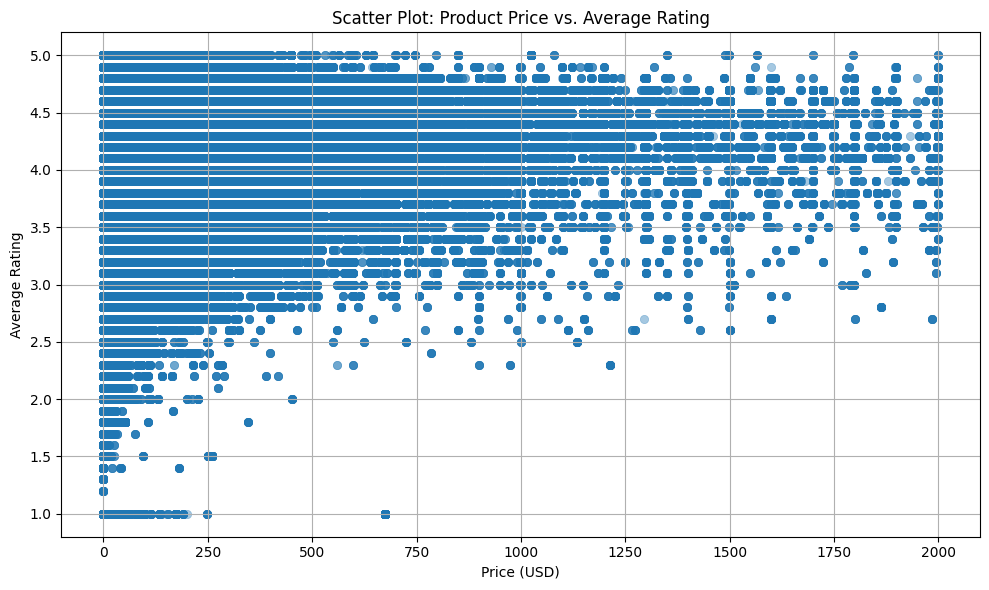

In [ ]:
# is there a relationship between price and user rating?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df[train_df["price"] < 2000], x='price', y='average_rating', alpha=0.4, edgecolor=None)

plt.title("Scatter Plot: Product Price vs. Average Rating")
plt.xlabel("Price (USD)")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
train_df["price"].corr(train_df["average_rating"])

0.04368258448081556

Given the correlation between price and average rating is very close to 0 and the plot does not follow any linear pattern, we can conclude there is no linear relationship between price and rating.

In [9]:
# top 10 most reviewed stores

filtered_df = train_df[train_df['store'] != 'Unknown']

top_10_most_reviewed = (filtered_df.groupby(['store', 'category']).agg(review_count=('average_rating', 'count'), average_rating=('average_rating', 'mean'))
    .reset_index().sort_values(['review_count', 'average_rating'], ascending=[False, False]).head(10))

top_10_most_reviewed.columns = ['Store', 'Category', 'Review Count', 'Average Rating']

display(top_10_most_reviewed)

,Store,Category,Review Count,Average Rating
22462,Amazon,Electronics,607820,4.47
175765,Hanes,Clothing_Shoes_and_Jewelry,273072,4.36
350076,SAMSUNG,Electronics,262306,4.34
22474,Amazon Basics,Electronics,251621,4.49
372835,Skechers,Clothing_Shoes_and_Jewelry,248632,4.44
361960,SanDisk,Electronics,211567,4.57
249206,Logitech,Electronics,199904,4.33
376965,Sony,Electronics,191893,4.19
300912,OXO,Home_and_Kitchen,189820,4.58
22476,Amazon Basics,Home_and_Kitchen,186480,4.55


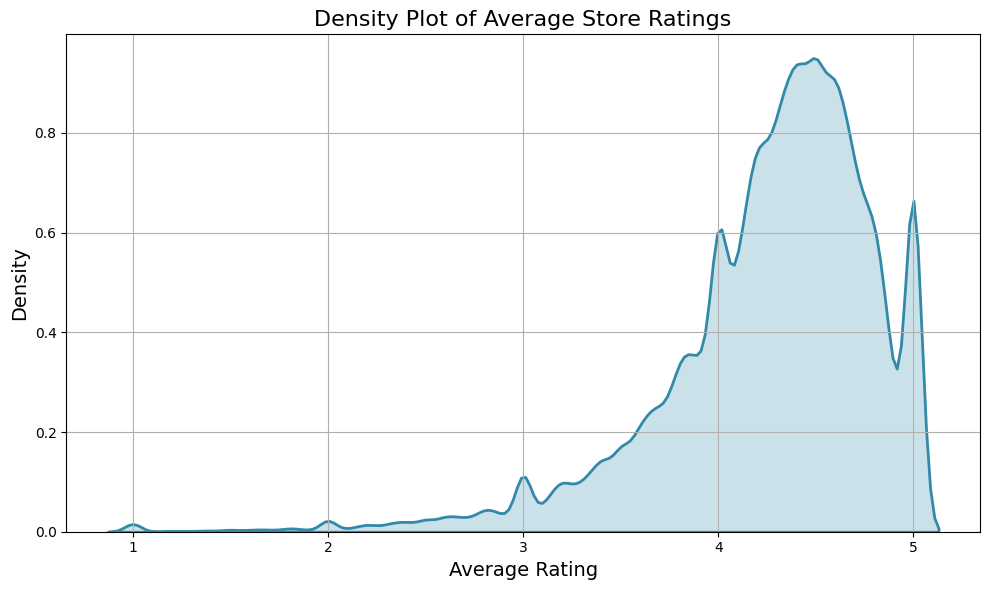

In [7]:
# is store a helpful feature for product recommendation?
store_avg_ratings = (train_df.groupby('store')['rating'].mean().dropna())

plt.figure(figsize=(10, 6))
sns.kdeplot(store_avg_ratings, fill=True, color="#3289a8", linewidth=2)

plt.title("Density Plot of Average Store Ratings", fontsize=16)
plt.xlabel("Average Rating", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

This non-uniform distribution shows that different stores tend to receive different ratings, which means stores can be a useful feature in our analysis.

## Product Analysis

In [19]:
# most popular products for each category (most reviews)
product_counts = train_df.groupby(['category', 'parent_asin']).size().reset_index(name='review_count')

product_counts_sorted = product_counts.sort_values('review_count', ascending=False)

top_products = product_counts_sorted.groupby('category').first().reset_index().rename(columns={'parent_asin': 'top_product'})

top_products_titles = top_products.merge(train_df[['parent_asin', 'title']], how='left', left_on='top_product', right_on='parent_asin').drop_duplicates(['category'])

display(top_products_with_title[['category', 'title', 'review_count']])

,category,title,review_count
0,Arts_Crafts_and_Sewing,MumCraft Multipurpose Sewing Clips with Tin Bo...,1628
1628,Beauty_and_Personal_Care,essence | Lash Princess False Lash Effect Masc...,5588
7216,Cell_Phones_and_Accessories,amFilm Screen Protector 4.7“ for Apple iPhone ...,6108
13324,Clothing_Shoes_and_Jewelry,Funny Civil Engineers TShirt I'm A Crazy Civil...,72450
85774,Electronics,"Fire TV Stick with Alexa Voice Remote, streami...",44837
130611,Grocery_and_Gourmet_Food,San Francisco Bay Compostable Coffee Pods - Fo...,6596
137207,Health_and_Household,Healing Solutions 10ml Oils - Cassia Essential...,16045
153252,Home_and_Kitchen,Mellanni RV Bedding Short Queen - Double Brush...,29364
182616,Movies_and_TV,None,19768
202384,Office_Products,"Amazon Basics 15-Sheet Cross-Cut Paper, CD Cre...",3467


/var/folders/2j/3hckwvr56tsd009t_g61_0240000gp/T/ipykernel_7733/2782203675.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


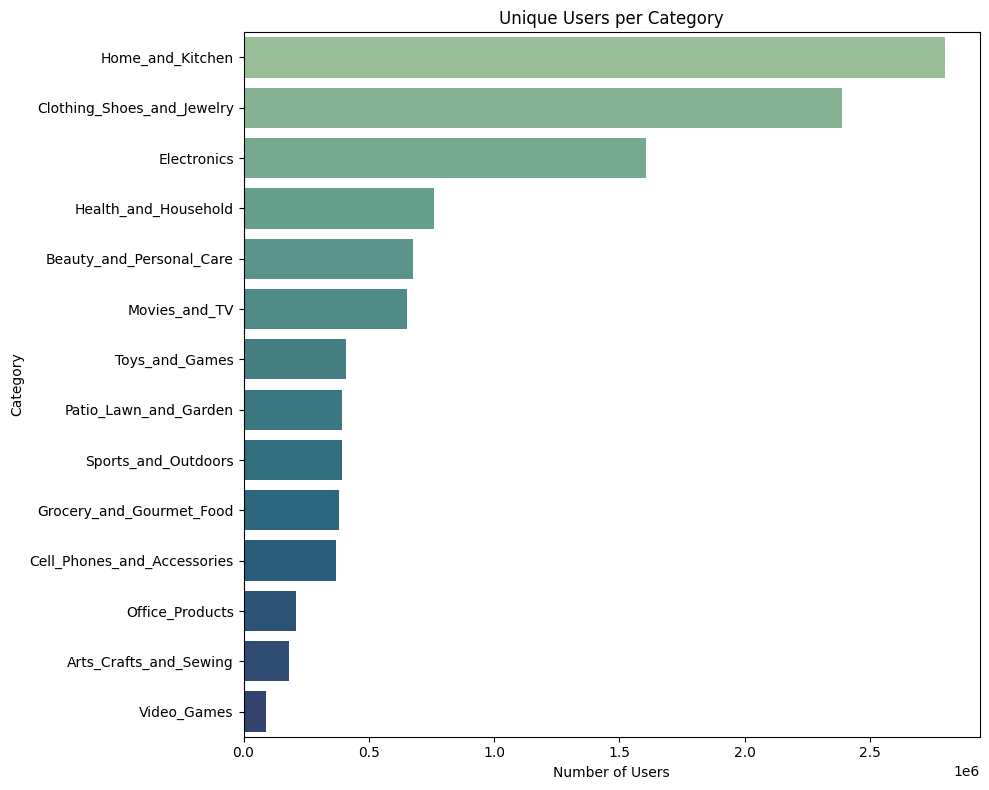

/var/folders/2j/3hckwvr56tsd009t_g61_0240000gp/T/ipykernel_7733/2782203675.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


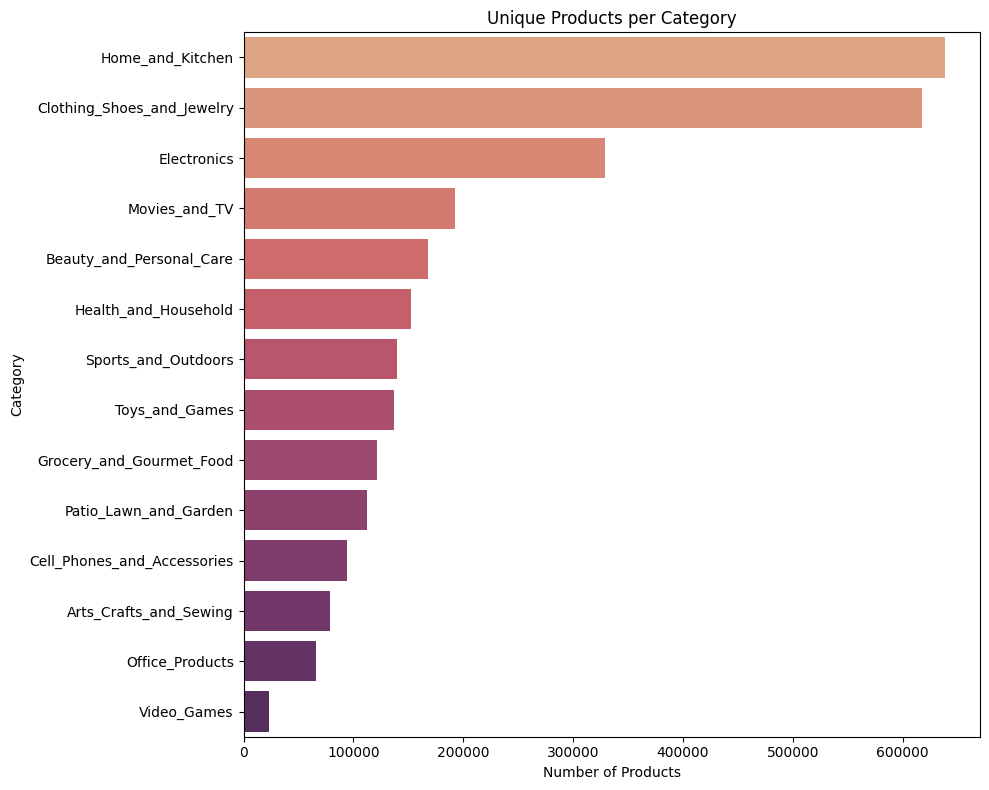

/var/folders/2j/3hckwvr56tsd009t_g61_0240000gp/T/ipykernel_7733/2782203675.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


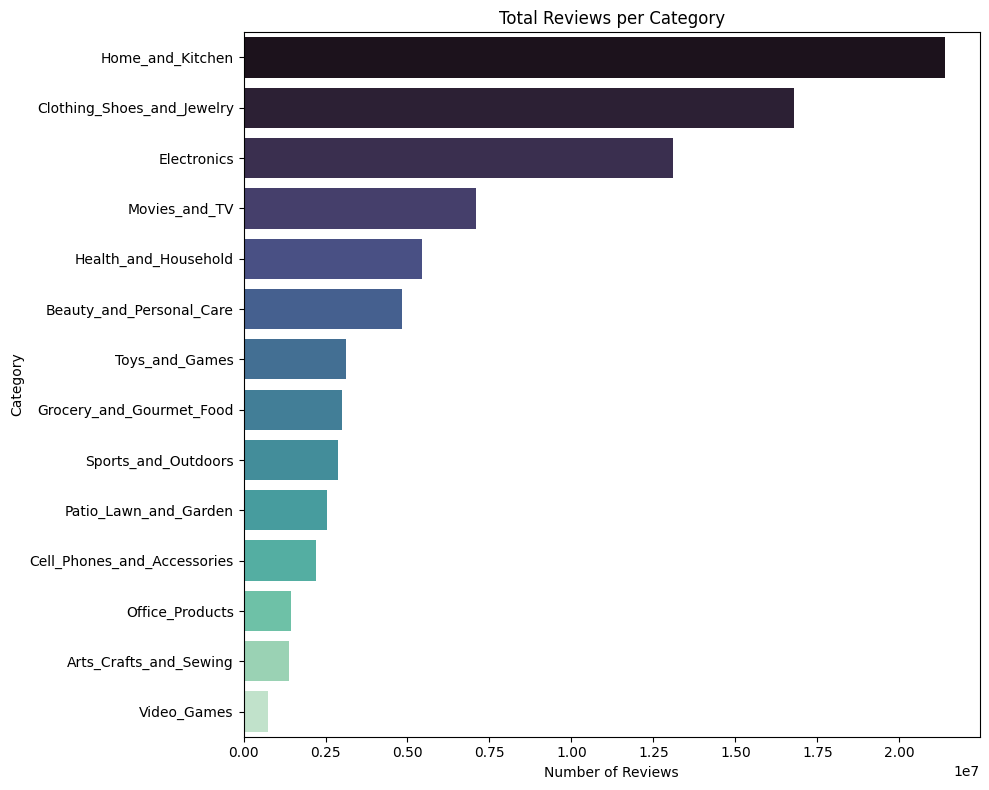

In [22]:
category_stats = train_df.groupby('category').agg(unique_users=('user_id', 'nunique'), 
                                                  unique_products=('parent_asin', 'nunique'),
                                                  total_reviews=('parent_asin', 'count')).reset_index()

category_stats_users = category_stats.sort_values('unique_users', ascending=False)
category_stats_products = category_stats.sort_values('unique_products', ascending=False)
category_stats_reviews = category_stats.sort_values('total_reviews', ascending=False)

# plot number of unique users per category
plt.figure(figsize=(10, 8))
sns.barplot(data=category_stats_users, x='unique_users', y='category', palette='crest')
plt.title("Unique Users per Category")
plt.xlabel("Number of Users")
plt.ylabel("Category")
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.show()

# plot number of unique products per category
plt.figure(figsize=(10, 8))
sns.barplot(data=category_stats_products, x='unique_products', y='category', palette='flare')
plt.title("Unique Products per Category")
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
plt.tight_layout()
plt.show()

# plot total reviews per category
plt.figure(figsize=(10, 8))
sns.barplot(data=category_stats_reviews, x='total_reviews', y='category', palette='mako')
plt.title("Total Reviews per Category")
plt.xlabel("Number of Reviews")
plt.ylabel("Category")
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.show()

For all 3 graphs, we can see:

1. Home and Kitchen
2. Clothing, Shoes, and Jewelry
3. Electronics

are the largest and most popular categories for users to review. Thus, our model may be biased to recommend products from these categories even if they are not relevant to a user.

# Temporal Analysis

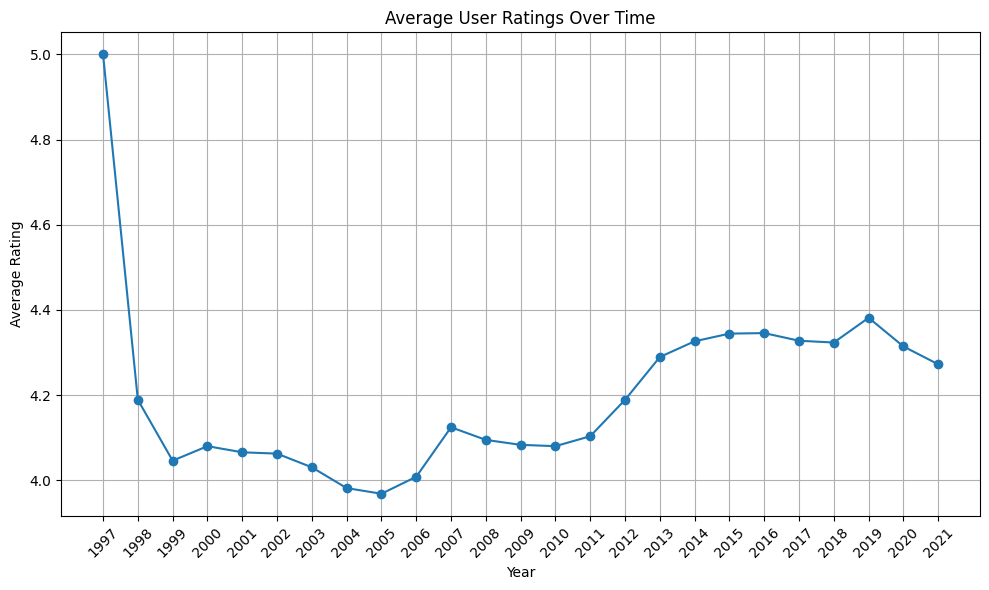

In [ ]:
# average user ratings over time
ratings_by_year = train_df.groupby('year')['rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(ratings_by_year['year'], ratings_by_year['rating'], marker='o')
plt.title('Average User Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.xticks(ratings_by_year['year']) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

While the average user ratings score was low between 2003 - 2006, there has been an upward trend as more ratings are becoming highly positive. This signifies that user preferences and product popularity are constantly changing.


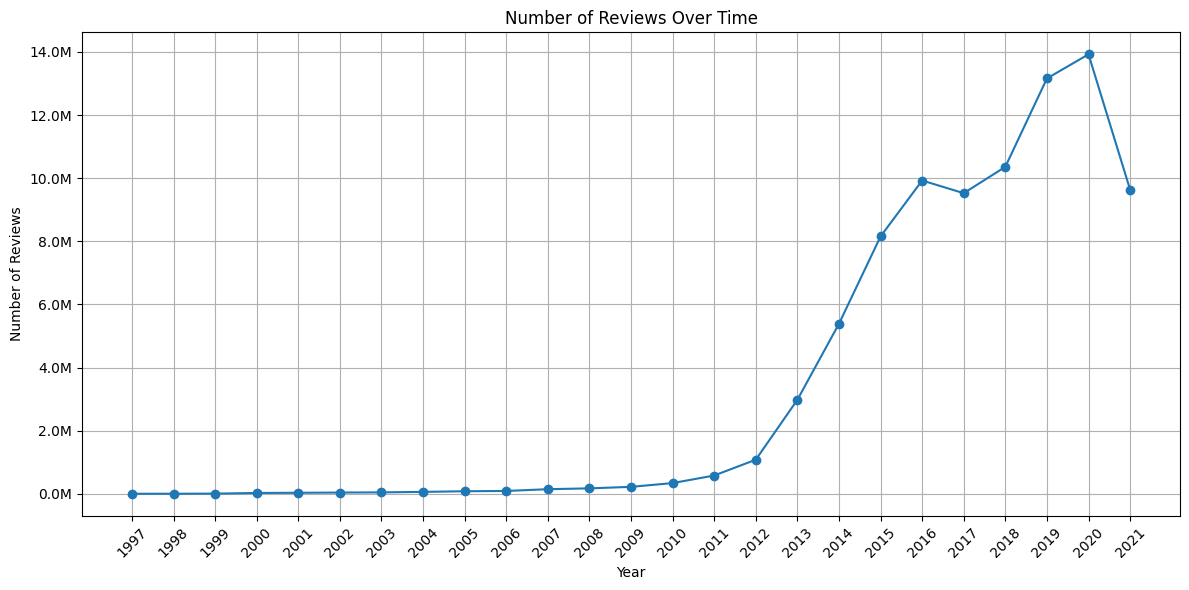

In [ ]:
# number of reviews over time
reviews_per_year = train_df.groupby('year').size().reset_index(name='review_count')

plt.figure(figsize=(12, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['review_count'], marker='o')
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(reviews_per_year['year'], rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

plt.tight_layout()
plt.show()

The number of reviews in 2021 decreased after a large period of increase. This may be because of COVID-19 as countries started quarantining around early 2020 and less people were ordering items from Amazon.

We can now save our filtered dataset to train various recommendation systems in future notebooks.

In [ ]:
train_df.to_parquet("gs://amazon-reviews-project/filtered_train_df.parquet", engine="pyarrow", index=False)